In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [186]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [167]:
# Doing lots of datetime coversions, just for practice, not neccecary
# Grab last data point
last_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Covert to datetime, caculate date of 1 year prior, then covert back to string
year_ago = (dt.date(2017, 8, 23) - dt.timedelta(days=365)).strftime("%Y-%m-%d")
# Grabbing all datapoints in the last year
precip_last_12 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>year_ago).all()
# Converting date strings to datetime then create a dataframe
datelist=[]
preciplist=[]
for row in precip_last_12:
    # split string by '-' then covert each section to integer using mapping then input into datetime constructor
    datelist.append(dt.date(*list(map(int, row[0].split('-')))))
    preciplist.append(row[1])
precip_df = pd.DataFrame({'date':datelist,'precip':preciplist})


In [184]:
last_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_point[0]

'2017-08-23'

Text(0.5, 0, 'date')

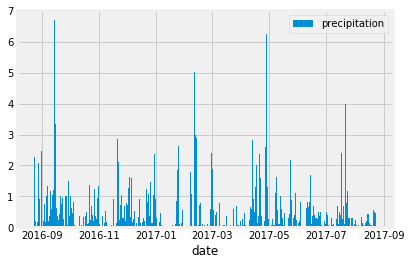

In [110]:
# plot using matplotlib and some formatting
# Using plt.bar instead of df.plot.bar because the formatting was easier
plt.bar(precip_df['date'],precip_df['precip'],label="precipitation",width=1)
plt.legend()
plt.xlabel('date')

![precipitation](Images/precipitation.png)

In [97]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df['precip'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precip, dtype: float64

![describe](Images/describe.png)

In [120]:
# Design a query to show how many stations are available in this dataset?
# Using both ID or station works
session.query(Station.id).distinct().count()

9

In [125]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [132]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

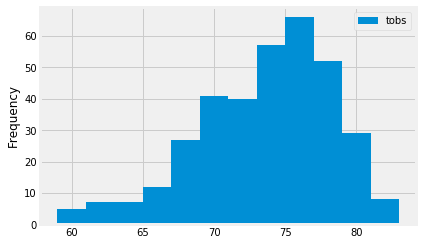

In [142]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date>year_ago).statement
station_df = pd.read_sql_query(highest, session.bind)
station_df.plot.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [136]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [170]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Choosing trip dates to be 8-01 to 8-15 
trip_temps = calc_temps('2016-08-01', '2016-08-15')
trip_temps

[(71.0, 78.17525773195877, 83.0)]

Text(0, 0.5, 'Temp(F)')

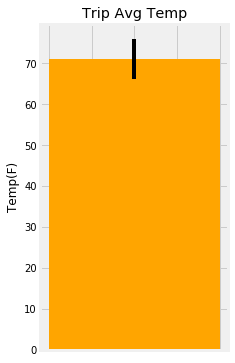

In [171]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(x=0.5, height=trip_temps[0][0],width=0.4,color='orange')
plt.errorbar(x=0.5,y=trip_temps[0][0], yerr=trip_temps[0][2]-trip_temps[0][1],ecolor='black')
plt.xticks=[]
frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
fig = plt.gcf()
fig.set_size_inches(3,6)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')

In [187]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Missing a 7th value compared to the example output, not sure what it is, have 1 station id, 2 station name, 3 prcp sum, 4 lat, 5 long, 6 elevation
session.query(Measurement.station,Station.name, func.sum(Measurement.prcp), Station.latitude,Station.longitude,Station.elevation).filter(Measurement.station==Station.station).filter(Measurement.date>='2016-08-01').filter(Measurement.date<='2016-08-15').group_by(Measurement.station).order_by(func.sum(Measurement.tobs).desc()).all()


[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  1.3200000000000003,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  0.5900000000000001,
  21.2716,
  -157.8168,
  3.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  6.759999999999997,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 4.35, 21.4234, -157.8015, 14.6),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  7.809999999999999,
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  1.1600000000000001,
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 'PEARL CITY, HI US', 0.18, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


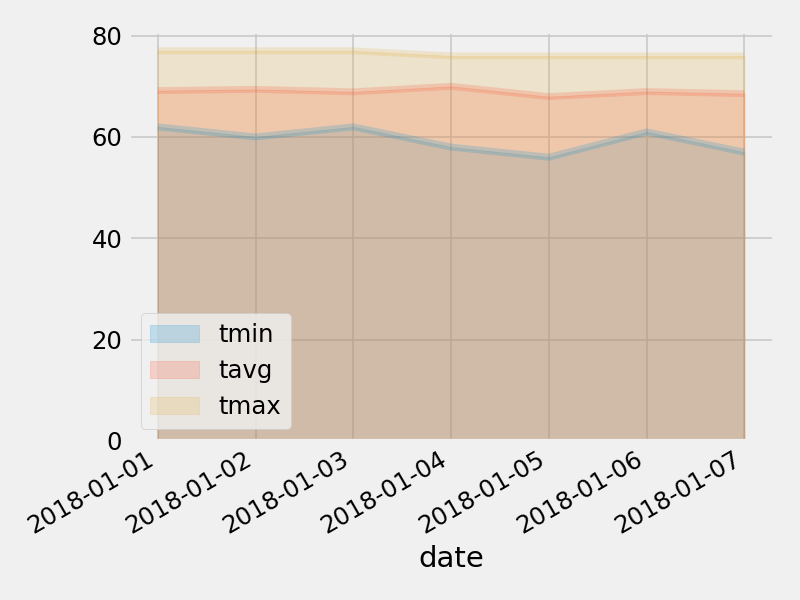

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
